In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [2]:
!nvidia-smi

Thu Jun 24 10:40:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 24.5MB/s 


In [4]:
import imageio
from tensorflow_docs.vis import embed
import cv2

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')
  
def generate_movies(n_samples=10,n_frames=15):
    row = 250
    col = 250
    movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float64)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float64)

    for i in range(n_samples):
        n = np.random.randint(3, 8)

        for j in range(n):
            xstart = np.random.randint(100, 140)
            ystart = np.random.randint(100, 140)
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1
            w = np.random.randint(4, 8)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                movies[i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0] += 1

                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    movies[i,t,x_shift - w - 1 : x_shift + w + 1,y_shift - w - 1 : y_shift + w + 1,0] += (noise_f * 0.1)
                
    movies[movies >= 1] = 1
    return movies


def resize_video(vid):
  res = np.ndarray((vid.shape[0], vid.shape[1], 128, 128, 1))
  for i in range(vid.shape[0]):
    for j in range(vid.shape[1]):
      d = vid[i, j, :, :, :]
      d = cv2.resize(d, dsize=(128, 128))
      d = d.reshape((128, 128, 1))
      res[i, j] = d
  return res


def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

In [5]:
data = generate_movies(n_samples=300)
data.shape

(300, 15, 250, 250, 1)


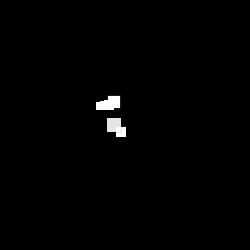

In [6]:
to_gif(data[100])

Displaying frames for example 230.


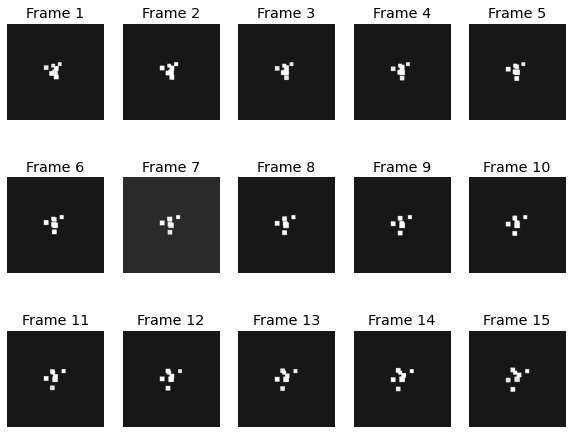

In [7]:
fig, axes = plt.subplots(3, 5, figsize=(10, 8))

data_choice = np.random.choice(range(len(data)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(data[data_choice][idx][:, : ,0], cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

print(f"Displaying frames for example {data_choice}.")
plt.show()

In [8]:
x_train, y_train = create_shifted_frames(data)
x_train.shape, y_train.shape

((300, 14, 250, 250, 1), (300, 14, 250, 250, 1))

In [9]:
idx = np.random.randint(0, len(x_train), int(0.1*len(x_train)))
r_idx = [i for i in range(len(x_train)) if i not in idx]
x_test = x_train[idx]
y_test = y_train[idx]
x_train, y_train = x_train[r_idx], y_train[r_idx]
del data

In [ ]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))
x = layers.TimeDistributed( layers.Conv2D(32, (3, 3), padding='same', strides=(2, 2), activation='relu') )(inp)
x = layers.TimeDistributed( layers.BatchNormalization() )(x)
x = layers.TimeDistributed( layers.Dropout(0.4) )(x)
x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), strides=(2, 2), return_sequences=True, activation="relu")(x)
x = layers.TimeDistributed( layers.BatchNormalization() )(x)
x = layers.TimeDistributed( layers.Dropout(0.4) )(x)
x = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', strides=(2, 2), return_sequences=True, activation="relu")(x)
x = layers.TimeDistributed( layers.BatchNormalization() )(x)
x = layers.TimeDistributed( layers.Dropout(0.4) )(x)


x = layers.TimeDistributed( layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu') )(x)
x = layers.TimeDistributed( layers.Dropout(0.2) )(x)
x = layers.TimeDistributed( layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu') )(x)
x = layers.TimeDistributed( layers.Dropout(0.2) )(x)
x = layers.TimeDistributed( layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu') )(x)
x = layers.TimeDistributed( layers.Dropout(0.2) )(x)
x = layers.Conv3DTranspose(1, (1, 3, 3), padding='same', activation='relu')(x)

model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),
)
model.summary()

In [10]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))
cnn = layers.TimeDistributed( layers.Conv2D(32, (3, 3), padding='same', strides=(2, 2), activation='relu') )(inp)
cnn = layers.TimeDistributed( layers.BatchNormalization() )(cnn)
cnn = layers.TimeDistributed( layers.Dropout(0.4) )(cnn)
cnn = layers.TimeDistributed( layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu') )(cnn)
cnn = layers.TimeDistributed( layers.BatchNormalization() )(cnn)
cnn = layers.TimeDistributed( layers.Dropout(0.4) )(cnn)
cnn = layers.TimeDistributed( layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu') )(cnn)
cnn = layers.TimeDistributed( layers.BatchNormalization() )(cnn)
cnn = layers.TimeDistributed( layers.Dropout(0.4) )(cnn)

x = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=True, activation="relu")(cnn)

x = layers.TimeDistributed( layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu') )(x)
x = layers.TimeDistributed( layers.Dropout(0.2) )(x)
x = layers.TimeDistributed( layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu') )(x)
x = layers.TimeDistributed( layers.Dropout(0.2) )(x)
x = layers.TimeDistributed( layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu') )(x)
x = layers.TimeDistributed( layers.Dropout(0.2) )(x)
x = layers.Conv3DTranspose(1, (1, 3, 3), padding='same', activation='relu')(x)

model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 250, 250, 1 0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 125, 125, 32 320       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 125, 125, 32 128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 125, 125, 32 0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 62, 62, 64)  18496     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 62, 62, 64)  256       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 62, 62, 64)  0     

In [11]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 10
batch_size = 1

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
244/244 [==============================] - 57s 131ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 2/10
244/244 [==============================] - 33s 137ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 3/10
244/244 [==============================] - 31s 129ms/step - loss: 0.0012 - val_loss: 9.4106e-04
Epoch 4/10
244/244 [==============================] - 32s 130ms/step - loss: 0.0011 - val_loss: 8.5038e-04
Epoch 5/10
244/244 [==============================] - 31s 129ms/step - loss: 9.8949e-04 - val_loss: 7.5170e-04
Epoch 6/10
244/244 [==============================] - 32s 129ms/step - loss: 9.0920e-04 - val_loss: 7.4875e-04
Epoch 7/10
244/244 [==============================] - 31s 129ms/step - loss: 8.5005e-04 - val_loss: 6.7215e-04
Epoch 8/10
244/244 [==============================] - 32s 130ms/step - loss: 8.0681e-04 - val_loss: 6.7174e-04
Epoch 9/10
244/244 [==============================] - 32s 129ms/step - loss: 7.6943e-04 - val_loss: 6.4284e-04
Epoch 10/10
244/244 [====

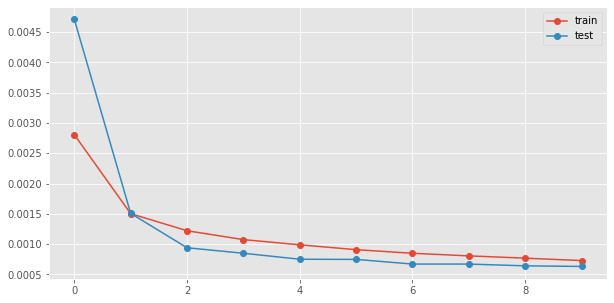

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], '-o')
plt.plot(history.history['val_loss'], '-o')
plt.legend(['train', 'test'])
plt.show()

(-0.5, 249.5, 249.5, -0.5)

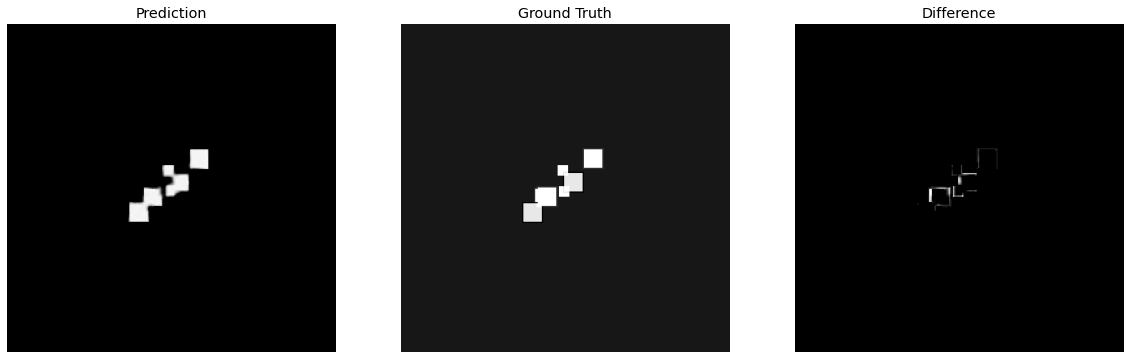

In [16]:
## Predict 8th frame
example = x_test[1]
frames = example[:8, ...]
original_frame = example[8, ...]
new_prediction = model.predict(np.expand_dims(frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(predicted_frame), cmap="gray")
plt.title(f"Prediction")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(original_frame), cmap="gray")
plt.title(f"Ground Truth")
plt.axis("off")
diff = original_frame - predicted_frame
diff[diff > 0.9] = 1.0
diff[diff < 0.1] = 0.0
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(diff), cmap="gray")
plt.title(f"Difference")
plt.axis("off")


(14, 250, 250, 1)


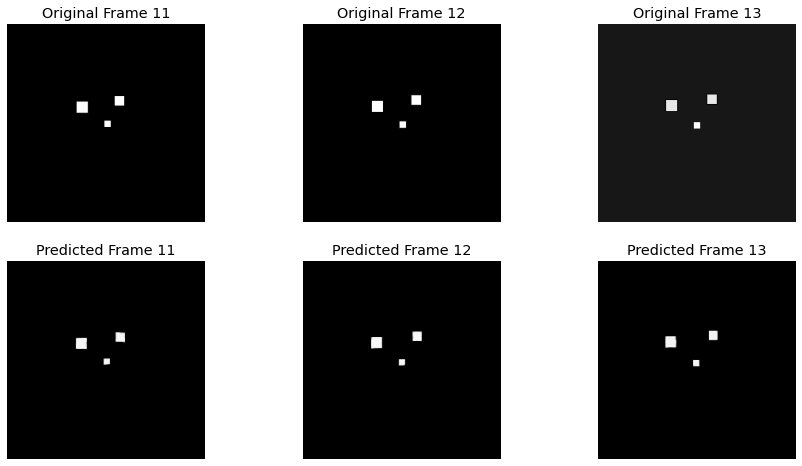

CPU times: user 1.89 s, sys: 35.2 ms, total: 1.93 s
Wall time: 3.47 s


In [29]:
%%time

example = x_test[2]
print(example.shape)

frames = example[:10, ...]
original_frames = example[10:, ...]

for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    frames = np.concatenate((frames, predicted_frame), axis=0)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Original Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[11:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Predicted Frame {idx + 11}")
    ax.axis("off")

plt.show()


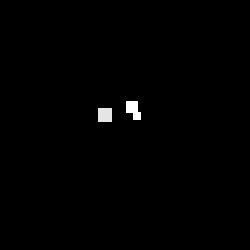

In [30]:
fs = np.concatenate([frames[:11, :, :, :], new_frames])
fs.shape
to_gif(fs)


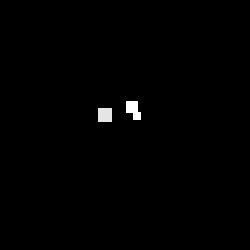

In [31]:
to_gif(example)